# Lab 6: Topic Modelling

This lab explores topic modelling with Latent Dirichlet Allocation (LDA).

### Learning Outcomes

* Be able to apply Latent Dirichlet Allocation (LDA) using the Gensim library
* Know how to interpret the outputs of LDA for a specific document or topic 
* Know how to apply TF-IDF to improve the vector representations of the documents.

### Outline

* Implementing LDA Topic Modelling
* TF-IDF vectors
* Visualizing Topic Modelling Results
* Optional: HDP model as an alternative to LDA

### How To Complete This Lab

Read the text and the code then look for 'TODOs' that instruct you to complete some missing code. Look out for 'QUESTIONS' which you should try to answer before moving on to the next cell. Aim to work through the lab during the scheduled lab hours. To get help, you can talk to TAs or the lecturer during the labs, post questions to Blackboard (anonymously) or on Teams in the QA channel (with your name), or ask a question in the Wednesday live sessions. 

As you work through the notebooks, please make a note of any code that is unclear to you.

The labs *will not be marked*. However, they will prepare you for the coursework, so try to keep up with the weekly labs and have fun with the exercises! To understand what's going on inside the methods we use here, make sure to watch the lecture videos for the same week.

## Step 1: Load the Dataset

Topic modelling is uses unsupervised learning to extract the topics (represented as a probability distribution over words) that occur in a collection of documents. Let's load some data to apply topic modelling to from the 20 newsgroups dataset:

In [1]:
from sklearn.datasets import fetch_20newsgroups

# We will use the 'train' split for learning the topics in an unsupervised manner:
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, remove=('headers', 'footers', 'quotes'))

# We will apply our learned topic model to the 'test' split later on:
newsgroups_test = fetch_20newsgroups(subset='test', shuffle=True, remove=('headers', 'footers', 'quotes'))

Newsgroups are internet discussion groups, where users discuss a range of topics. Despite the name, the posts do not usually contain news. This dataset contains posts from 20 different newsgroups. Each newsgroup has a particular theme. We can view the list of newsgroups in the training split as follows:

In [2]:
print(newsgroups_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


When working with a new dataset, it is always good to play around with the data and see what we have, and how to find everything :) 
```newsgroups_train``` is a Python dictionary. Let's look at the keys and the types of objects stored in the dictionary:

In [3]:
for i in newsgroups_train:
    print(i, type(newsgroups_train[i]))

data <class 'list'>
filenames <class 'numpy.ndarray'>
target_names <class 'list'>
target <class 'numpy.ndarray'>
DESCR <class 'str'>


The ```data``` item is a list of raw text documents. This is all we need for topic modelling, so we can ignore the ```target``` and ```DESCR``` keys for now.

The code below prints out the first post in ```data```:

In [4]:
print('DOCUMENT 0:')
print(newsgroups_train.data[0])

DOCUMENT 0:
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


## Step 2: Data Preprocessing

To apply topic modelling, we need to first preprocess the data. We will carry out the following steps using the same approach as previous labs:
* Tokenise the posts using NLTK's word_tokenize() function
* Remove non-word tokens and tokens with length less than 3 (likely to be numbers and punctuation that are not related to specific topics) and longer than 15 (probably URLs, codes, andbadly formatted tokens rather than proper words)
* Convert the tokens to lower case
* Remove stopwords: we have not used this step before; it removes tokens such as 'the' and 'a' that appear in a list of very common words, because these words do not tell us much about topics
* Lemmatize the tokens using WordNetLemmatizer to convert verbs to their root forms

We're going to introduce another library, [Gensim](https://radimrehurek.com/gensim/), which contains a lot of useful tools for topic modelling, text normalisation, and vector representations of words or documents (embeddings). For preprocessing, we will use the list of stopwords provided by Gensim. For topic modelling, removing stopwords can be particularly useful to remove noise and reduce the model complexity. Run the code below to preprocess the text:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer 
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS # find stopwords
import numpy as np

np.random.seed(400)  # We fix the random seed to ensure we get consistent results when we repeat the lab.

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in simple_preprocess(text) :  # Tokenize, remove very short and very long words, convert to lower case, remove words containing non-letter characters
        if token not in STOPWORDS:
            result.append(WordNetLemmatizer().lemmatize(token, 'v'))
            
    return result

# Create a list of preprocessed documents
processed = []
for doc in newsgroups_train.data:
    processed.append(preprocess(doc))

Now that we have finished the preprocessing, we need to construct the input for Gensim's topic modelling method. We do so by constructing a dictionary with word<->id mappings, then converting that into a bag of words, which will be the input to our model.

In [6]:
from gensim.corpora import Dictionary

dictionary = Dictionary(processed) # construct word<->id mappings - it does it in alphabetical order
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary(66025 unique tokens: ['addition', 'body', 'bricklin', 'bumper', 'call']...)


# 3. Latent Dirichlet Allocation (LDA)

Now we are ready to perform topic modelling using LDA. 

We are going to try 20 topics in the document corpus: the number of newsgroups is also 20, so perhaps we will find topics that correspond with the newsgroups. We will be running LDA using all CPU cores to parallelize and speed up model training.

Gensim provides the ```LdaModel``` class. When we construct an ```LdaModel``` object, some of the parameters we will be tweaking are:
   * *num_topics*, the number of requested latent topics to be extracted from the training corpus. <br>
   * *id2word*, a mapping from word ids (integers) to words (strings). It is used to determine the vocabulary size, as well as for debugging and topic printing. <br>
   * *workers*, the number of extra processes to use for parallelization. Uses all available cores by default. <br>


In [7]:
from gensim.models import LdaModel

lda_model =  LdaModel(bow_corpus, 
                      num_topics=20, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

TODO 3.1: run the code below to print out the topic distributions found by LDA. Can you find any topics that relate to specific newsgroups (newsgroups_train.target_names)? Can you find any other meaningful topics? Topic 1 could be windows, 2 middle east politics, 3 could also be windows, 4 could be sci.crypt  

In [8]:
print(newsgroups_train.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


TODO 3.2: What do the values beside each word mean? The numbers next to each word most likely represnet the weight of those words.

In [9]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.647*"ax" + 0.048*"max" + 0.008*"pl" + 0.006*"tm" + 0.005*"ei" + 0.005*"di" + 0.005*"bhj" + 0.004*"wm" + 0.004*"giz" + 0.004*"ey"


Topic: 1 
Words: 0.036*"edu" + 0.021*"com" + 0.012*"server" + 0.011*"sun" + 0.010*"cs" + 0.010*"db" + 0.009*"list" + 0.009*"available" + 0.009*"motif" + 0.008*"window"


Topic: 2 
Words: 0.012*"say" + 0.012*"people" + 0.009*"kill" + 0.008*"armenian" + 0.008*"come" + 0.007*"go" + 0.007*"armenians" + 0.007*"turkish" + 0.006*"war" + 0.006*"live"


Topic: 3 
Words: 0.011*"file" + 0.010*"drive" + 0.010*"windows" + 0.010*"use" + 0.009*"thank" + 0.009*"card" + 0.008*"program" + 0.008*"know" + 0.008*"work" + 0.008*"run"


Topic: 4 
Words: 0.046*"key" + 0.027*"chip" + 0.013*"encryption" + 0.012*"bite" + 0.011*"clipper" + 0.010*"use" + 0.009*"number" + 0.007*"phone" + 0.007*"encrypt" + 0.006*"know"


Topic: 5 
Words: 0.035*"file" + 0.031*"entry" + 0.018*"program" + 0.014*"entries" + 0.014*"output" + 0.013*"section" + 0.012*"rule" + 0.010*"build" + 

## Testing on unseen data

Now that we have a trained LDA mode, we can run it on a new, unseen document to get the breakdown of topics. Let's test the model on a document from the test set. First, get the raw document, then apply preprocessing:

In [10]:
test_document_idx = 0
unseen_document = newsgroups_test.data[test_document_idx]
print(unseen_document)

print(f' This document is from newsgroup {newsgroups_test.target_names[newsgroups_test.target[test_document_idx]]}')

# Data preprocessing step for the unseen document - It is the same preprocessing we have performed for the training data
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for idx, count in bow_vector:
    print(f'{dictionary[idx]}: {count}')

I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.
 This document is from newsgroup rec.autos
early: 1
know: 1
model: 2
hear: 2
summer: 1
time: 2
tell: 1
value: 2
buy: 1
usually: 1
year: 1
little: 1
feature: 1
word: 1
best: 1
book: 2
performance: 1
mid: 1
far: 1
le: 1
differences: 1
spring: 1
demand: 1
se: 1
confuse: 1
curious: 1
prefereably: 1


Now, run our preprocessed document through the LDA model as follows to obtain $\boldsymbol{\theta}^d$, the topic distribution (topics with zero probability are not shown):

We can examine the word-topic distributions for the topics associated with this document:

In [11]:
topic_distribution = lda_model[bow_vector]
print(topic_distribution)
for index, probability in sorted(topic_distribution, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t Topic: {}".format(index, probability, lda_model.print_topic(index, 5)))

[(9, 0.03468739), (12, 0.4836444), (14, 0.15132226), (15, 0.30533457)]
Index: 12
Probability: 0.48364439606666565	 Topic: 0.009*"new" + 0.009*"car" + 0.008*"price" + 0.008*"sell" + 0.008*"buy"
Index: 15
Probability: 0.30533456802368164	 Topic: 0.018*"think" + 0.015*"like" + 0.014*"know" + 0.012*"time" + 0.010*"go"
Index: 14
Probability: 0.15132226049900055	 Topic: 0.021*"god" + 0.010*"people" + 0.009*"believe" + 0.008*"jesus" + 0.007*"think"
Index: 9
Probability: 0.03468738868832588	 Topic: 0.020*"cx" + 0.015*"c_" + 0.013*"hz" + 0.010*"qs" + 0.010*"lk"


## Visualising Topics 

Let's compare the topics for some training set documents in the same newsgroup.

TODO 3.3: Complete the code below to define a function to retrieve the topic distributions for 10 documents in the ```talk.politics.mideast``` newsgroup.

In [64]:
from gensim.matutils import any2sparse

def get_document_ids_in_newsgroup(newsgroup_name, newsgroups_data):
    # retrieve a list of document indexes for documents with this target_name
    doc_idxs = []
    for i, target_i in enumerate(newsgroups_data.target):
        if newsgroups_data.target_names[target_i] == newsgroup_name:
            doc_idxs.append(i)
            
    print("There are {} documents in the newsgroup {}".format(len(doc_idxs), newsgroup_name))
            
    return doc_idxs


def get_topic_dists_in_newsgroup(newsgroup_name, lda_model, max_num_docs=10):
    doc_idxs = get_document_ids_in_newsgroup(newsgroup_name, newsgroups_train)
    
    # only use the first ten documents.
    if len(doc_idxs) > max_num_docs:
        doc_idxs = doc_idxs[:max_num_docs]
    print(doc_idxs)
    
    # Save each theta_d distribution to the list 'thetas':
    thetas = []
    
    for doc_idx in doc_idxs:
        ### COMPLETE THE CODE HERE
        
        # Get the document from newsgroups_train
        doc = newsgroups_train.data[doc_idx]
        
        # Apply preprocessing to get a bag-of-words vector:
        bow_vector = dictionary.doc2bow(preprocess(doc))
        
        # Use the LDA model to compute the topic distribution for this document:
        theta_d = lda_model[bow_vector]
        
        #######################
        
        thetas.append(theta_d)
    
    return thetas

Run the function above and print out the topic distributions:

In [65]:
thetas = get_topic_dists_in_newsgroup('talk.politics.mideast', lda_model, max_num_docs=10)
print(thetas)

print(get_topic_dists_in_newsgroup('alt.atheism', lda_model, max_num_docs=10))
print(get_topic_dists_in_newsgroup('comp.sys.ibm.pc.hardware', lda_model, max_num_docs=10))

There are 564 documents in the newsgroup talk.politics.mideast
[33, 54, 70, 91, 104, 133, 152, 160, 202, 219]
[[(2, 0.6436529), (7, 0.3318458), (15, 0.015131271)], [(2, 0.6020892), (5, 0.025420219), (8, 0.016252175), (13, 0.13333271), (14, 0.055681452), (15, 0.034020983), (17, 0.071603164), (19, 0.058327664)], [(2, 0.7734771), (8, 0.016268106), (13, 0.1273078), (14, 0.036894802), (17, 0.028794693)], [(2, 0.41018152), (8, 0.026231578), (9, 0.06430294), (13, 0.28817505), (14, 0.20253433)], [(11, 0.018936483), (13, 0.10978017), (14, 0.36264515), (15, 0.2858063), (16, 0.20839982)], [(2, 0.79514104), (4, 0.036440186), (13, 0.1496585)], [(2, 0.099440485), (4, 0.022048423), (5, 0.018008204), (7, 0.018886628), (12, 0.12625815), (13, 0.38428685), (15, 0.20807904), (16, 0.015143129), (17, 0.09985643)], [(2, 0.8681504), (12, 0.09584244)], [(8, 0.09386088), (9, 0.046696465), (12, 0.05707933), (13, 0.22925258), (14, 0.2317718), (15, 0.30940914)], [(13, 0.34179902), (14, 0.20015672), (15, 0.20239258

The text output is quite hard to read. We can improve on it by making a bar chart with a distinct colour for each topic. The function below can be used to plot a simple bar chart using the ```matplotlib``` library. This will help us see which documents discuss the same topics. The height of each bar is the probability for that topic within the document, according to our model.

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# choose some colours for the topics
colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'teal', 'pink', 'purple',
           'orange', 'gray', 'lime', 'darkgreen', 'lightgray', 'navy', 'gold', 'crimson', 'darkgray', 'fuchsia']

def convert_theta_sparse_to_dense(theta_d_sparse, num_topics):
    theta_d = np.zeros(num_topics)  # an empty array
    
    # split the output from lda_model into two lists
    active_topics_in_d, probs = map(list, zip(*theta_d_sparse))
    # record the values in theta_d
    for i, topic in enumerate(active_topics_in_d):
        if topic >= num_topics:
            break
            
        theta_d[topic] = probs[i]
    
    return theta_d

# a function for producing a bar chart for a document
def plot_theta(thetas, d, num_docs, num_topics):
    plt.subplot(int(num_docs/3) + 1, 3, d+1)   # make a set of subplots inside a figure, with four subplots per row
    
    theta_d = convert_theta_sparse_to_dense(thetas[d], num_topics)
    
    # plot the results so that the same topics always occur at the same place along the x axis.
    plt.bar(x=np.arange(len(theta_d)), height=theta_d, color=colours, tick_label=np.arange(num_topics))

TODO 3.4: use the function to plot the topic distributions of the 10 documents we selected from the ```talk.politics.mideast``` newsgroup. What do you notice? Are there any topics the documents have in common? Any they do not? Refer back to the printed list of topics above to find the most common topic in this newsgroup.

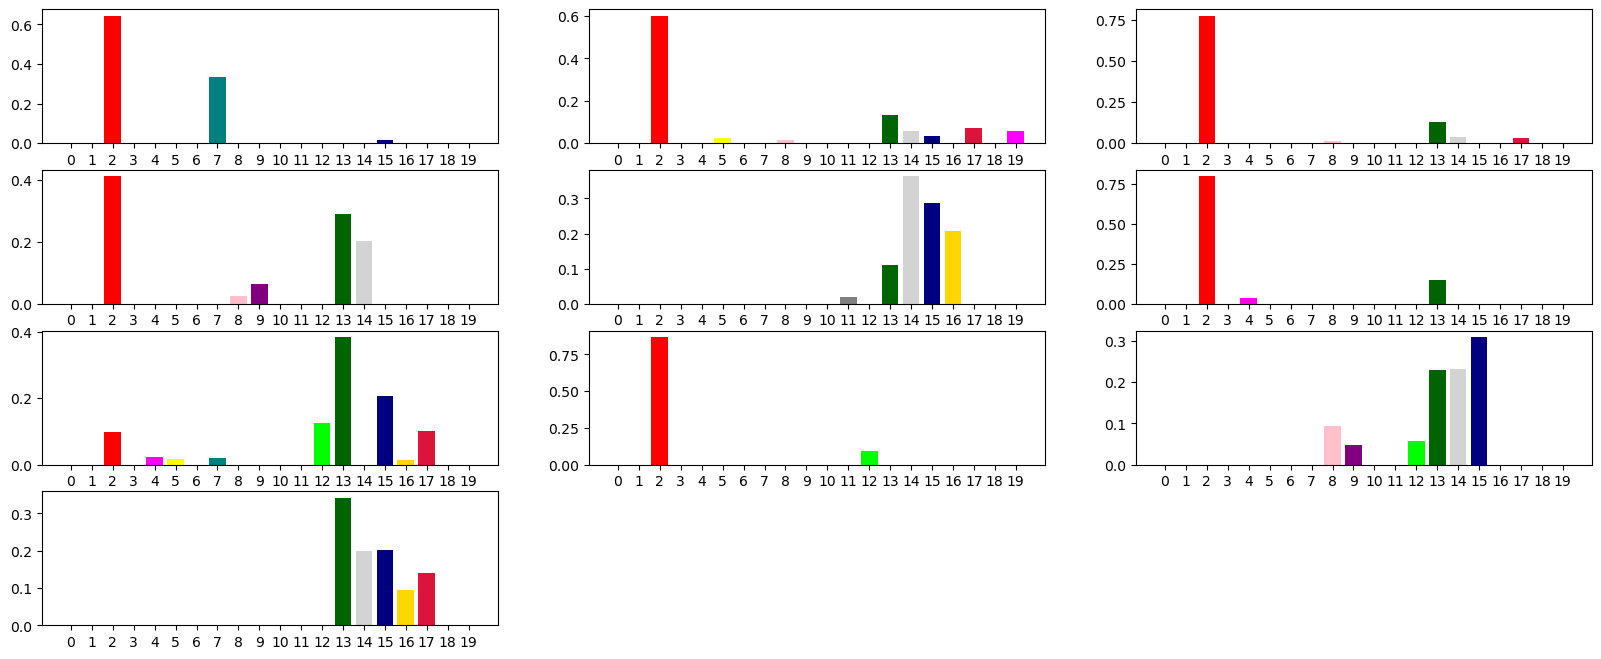

In [67]:
plt.figure(figsize=(20,8))

### WRITE YOUR OWN CODE HERE
num_docs = 10
num_topics = 20
#theta_d = convert_theta_sparse_to_dense(thetas[2], num_topics)
#loop through d
for d in range(num_docs):
    plot_theta(thetas,d,num_docs,num_topics)
############################

plt.show()

Now, let's look at how the topics we've found with LDA relate to the newsgroups (the targets in the training set).

The code below iterates over the newsgroups, computing the topic distribution for each document in that particular newsgroup. 

TODO 3.5: Complete the function below to compute the mean topic distribution, $\boldsymbol\theta$, for each newsgroup. Hint: use the ```mean``` function from Numpy. 

In [68]:
# Create a numpy array which will store a matrix of values. Rows correspond to newsgroups and columns to LDA topics.
def get_newsgroups_mean_topics(lda_model, num_topics):
    
    # Create a matrix where each row corresponds to a newsgroup, and each column to a topic.
    # In each entry, we will save the mean probability of the topic for the documents in that newsgroup.
    mean_thetas = np.zeros((len(newsgroups_train.target_names), num_topics))

    print(mean_thetas.shape)
    for t, target_name in enumerate(newsgroups_train.target_names):
        # Obtain the thetas for the documents with this target name
        thetas_t_sparse = get_topic_dists_in_newsgroup(target_name, lda_model, max_num_docs=10)
        #print(np.array(thetas_t_sparse))
        
        # convert the thetas to a dense vector format
        thetas_t = []
        for theta_d_t_sparse in thetas_t_sparse:
            if not theta_d_t_sparse:
                continue  # if it's empty
            thetas_d = convert_theta_sparse_to_dense(theta_d_t_sparse, num_topics)
            thetas_t.append(thetas_d)
            
        # compute the mean theta for this newsgroup and store it in mean_thetas 
        ### WRITE YOUR OWN CODE HERE
        print(thetas_t[0])
        #t is topic
        #d is doc
        
        mean_thetas[t] = np.mean(thetas_t,axis=0)
        
        
        ###########################

        print(mean_thetas[t])
    return mean_thetas

print(get_newsgroups_mean_topics(lda_model, num_topics))

(20, 20)
There are 480 documents in the newsgroup alt.atheism
[15, 20, 65, 68, 80, 98, 115, 126, 135, 147]
[0.         0.         0.35966265 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.37858784 0.         0.24280588 0.         0.
 0.         0.        ]
[0.00266747 0.00266747 0.11974785 0.00468508 0.0037443  0.00266747
 0.00266747 0.00266747 0.00266747 0.00266747 0.00583608 0.00266747
 0.02236418 0.10754889 0.44652761 0.19461102 0.00266747 0.01667861
 0.0253962  0.01009237]
There are 584 documents in the newsgroup comp.graphics
[3, 16, 25, 82, 87, 99, 108, 125, 137, 150]
[0.         0.         0.         0.52005285 0.36739355 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
[0.         0.02643693 0.         0.44425918 0.04129027 0.
 0.         0.03353375 0.11288394 0.         0.00103271 0.
 0.03248186 0.00591076 0.         0.13715185 0.  

[0.         0.         0.64364278 0.         0.         0.
 0.         0.33184671 0.         0.         0.         0.
 0.         0.         0.         0.01514043 0.         0.
 0.         0.        ]
[0.         0.         0.4192294  0.         0.005849   0.00434265
 0.         0.03507341 0.0152598  0.01109994 0.         0.00189364
 0.02790087 0.17635546 0.10898338 0.10547102 0.03183107 0.03403053
 0.         0.00583268]
There are 465 documents in the newsgroup talk.politics.misc
[34, 96, 110, 170, 250, 253, 261, 311, 331, 347]
[0.         0.         0.33772469 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.58721042 0.         0.         0.
 0.         0.        ]
[0.         0.0414893  0.04812023 0.07202858 0.01534843 0.03540508
 0.00163043 0.00909864 0.01652019 0.         0.00562434 0.
 0.03435531 0.15559566 0.25506916 0.11985156 0.         0.12175806
 0.00703967 0.02568427]
There are 377 documents in the newsgroup talk.r

We can now plot a matrix ```mean_thetas``` using ```matplotlib``` using the code below.

TODO 3.6: which LDA topics are common across many newsgroups? Are there any topics that are specific to particular newsgroups? 

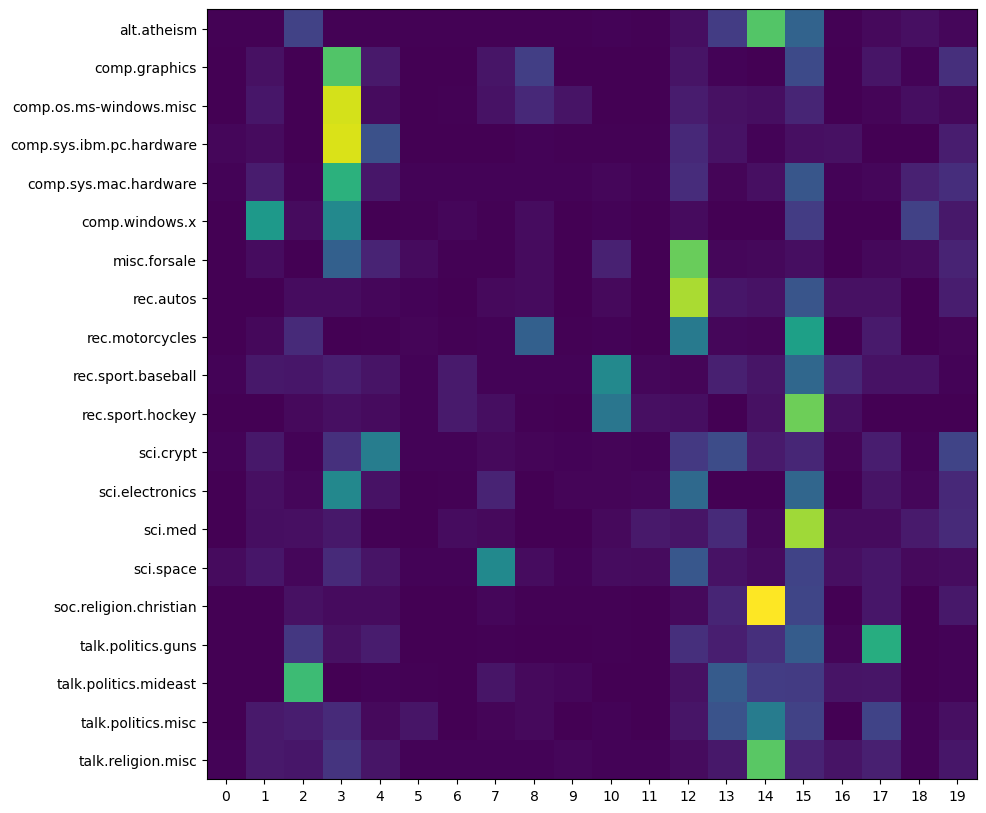

In [69]:
from IPython.display import clear_output

def plot_newsgroup_topic_matrix(model, num_topics):
    # Run the function we defined above to get the mean topic distributions:
    mean_thetas = get_newsgroups_mean_topics(model, num_topics)
    
    print(f'mean_thetas is a matrix of shape {mean_thetas.shape}')

    # Create a new figure
    plt.figure(figsize=(20,10))
    clear_output()

    # Plot the matrix as a 2-D grid, where colours represent the values.
    plt.imshow(mean_thetas)

    # Change the labels on the axes
    plt.yticks(range(len(newsgroups_train.target_names)), newsgroups_train.target_names )
    plt.xticks(range(num_topics))

    plt.show()
    
plot_newsgroup_topic_matrix(lda_model, num_topics)

# 4. Cosine Similarity and TF-IDF

For many tasks it is useful to compute similarity between documents, for example, if we want cluster documents into groups or to retrieve some documents that are similar to the one we are currently reading. In order to compute similarity or distance, we need to represent documents as numerical vectors. The code we have run so far produces bag-of-words vectors for each document, where each entry in vector is the count of word in the vocabulary.

Let's take a document from the 'rec.autos' newsgroup as a 'query' document and compare it to two others using cosine similarity. We'll take another one from 'rec.autos' and one from 'misc.forsale'. First let's show the documents and their bag of words vectors:

In [58]:
# get our first document
doc_idxs = get_document_ids_in_newsgroup('rec.autos', newsgroups_train)
doc_idx_0 = doc_idxs[19]
print(newsgroups_train.data[doc_idx_0].strip())
query_doc = bow_corpus[doc_idx_0]
# show the bag of words vector in sparse format. In each pair of numbers, the first is the word ID and the second is the word count.
for idx, count in query_doc:
    print(f'{dictionary[idx]}: {count}')

There are 594 documents in the newsgroup rec.autos
From article <1993Apr5.200048.23421@ucsu.Colorado.EDU>, by lorenzo@rintintin.Colorado.EDU (Eric Lorenzo):

--Let me put it like this.  The only similarity between the three models
  is the "300", or 3-liter engine displacement.  Actually, the SC300 (the
  coupe) and the GS300 (the funky-looking new sedan) share the same 3.0
  liter inline-six, and the ES300 (popular small sedan) uses 3.0 V6 shared
  with the Camry.  The SC300 is a luxury/sports coupe, the GS300 is the new
  luxury sedan, and the ES300 is the base executive sedan.  All three look
  completely different.

--Aamir Qazi
--
engine: 1
funky: 1
look: 2
model: 1
small: 1
sport: 1
base: 1
share: 2
actually: 1
edu: 2
like: 1
new: 2
use: 1
article: 1
different: 1
let: 1
luxury: 2
sc: 2
apr: 1
completely: 1
inline: 1
eric: 1
executive: 1
colorado: 2
es: 2
gs: 2
popular: 1
sedan: 4
aamir: 1
camry: 1
coupe: 2
displacement: 1
liter: 2
lorenzo: 2
qazi: 1
rintintin: 1
similarity: 1
ucs

In [59]:
# get a comparison document from the same newsgroup
doc_idx_1 = doc_idxs[17]
comparison_doc_1 = bow_corpus[doc_idx_1]
print(newsgroups_train.data[doc_idx_1].strip())
# show the bag of words vector in sparse format. In each pair of numbers, the first is the word ID and the second is the word count.
for idx, count in comparison_doc_1:
    print(f'{dictionary[idx]}: {count}')

Bzzt.
The manta was a two-door sedan in the US.
It had a 1900 engine.
Was sometimes referred to as an Opel 1900.
Manta's are also ve hot and fun cars too.
door: 1
engine: 1
ve: 1
cars: 1
hot: 1
refer: 1
fun: 1
bzzt: 1
manta: 2
opel: 1
sedan: 1


In [60]:
# get another comparison document from another newsgroup
doc_idxs = get_document_ids_in_newsgroup('misc.forsale', newsgroups_train)
doc_idx_2 = doc_idxs[2]
comparison_doc_2 = bow_corpus[doc_idx_2]
print(newsgroups_train.data[doc_idx_2].strip())

# show the bag of words vector in sparse format. In each pair of numbers, the first is the word ID and the second is the word count.
for idx, count in comparison_doc_2:
    print(f'{dictionary[idx]}: {count}')

There are 585 documents in the newsgroup misc.forsale
The front covers should be available from Sony.  Check with a local car
stereo shop.  You will probably (definitely) have to provide the units 
serial number and hopefully you had registered the warranty card.  I 
don't know the cost, but replacements have to be available to people
who damage the face cover, so it stands to reason that it can be replaced.

As to deterring theft:

When I worked for a stereo shop, we referred the customer to a Sony 800
number.  We would not sell the face, nor did we have them available.  Most
people who came in asking for the face cover (or a pullout sleave for that
matter) would look very disheartened to find that they acquired a deck
they couldn't use.  If theft occurs with these decks, notify Sony.  Serial
numbers do catch theives.
car: 1
know: 1
look: 1
card: 1
number: 3
hopefully: 1
people: 2
probably: 1
use: 1
check: 1
couldn: 1
available: 3
work: 1
sell: 1
shop: 2
come: 1
cost: 1
occur: 1
provi

To compute the similarity between the documents, we use cosine similarity:

$$similarity<v_1, v_2> = \frac{v_1 \cdot v_2}{|| v_1 || \cdot || v_2 ||}$$


TODO 4.1: Which document do you expect to have higher similarity to the query? Run the code below and see if it meets your expectations.

Expect the 1st document to be more similar

In [61]:
from gensim.matutils import cossim

cos_sim1 = cossim(query_doc, comparison_doc_1)
print(f'The cosine similarity between documents {doc_idx_0} and {doc_idx_1} is: {cos_sim1}')

cos_sim2 = cossim(query_doc, comparison_doc_2)
print(f'The cosine similarity between documents {doc_idx_0} and {doc_idx_2} is: {cos_sim2}')

The cosine similarity between documents 463 and 445 is: 0.1416481749175184
The cosine similarity between documents 463 and 30 is: 0.030886828649365476


The first and last documents share some common words, despite discussing different topics. We can alter our vector representations to focus more on keywords by using TF-IDF instead of bag of words.

TF-IDF is computed from two terms. First, the log of the term frequency:
$$ tf(t,d) = count(t,d)$$

We multiple the log term frequency by the inverse document frequencey, which is computed like this:

$$ idf(t) = \log_{2}\frac{N}{df(t)}$$

Gensim provides the TfidfModel class to compute TF-IDF vectors from our existing corpus object:

In [62]:
from gensim.models import TfidfModel

tfidf_model = TfidfModel(bow_corpus)

TODO 4.2: Apply the tfidf_model to `query_doc`, `comparison_doc_1` and `comparison_doc_2` to obtain a TF-IDF vector for each document. Print the results. Hint: you can apply the model in the same was a you applied lda_model to a bow_vector for an unseen test document.

In [89]:
#### WRITE YOUR OWN CODE HERE
#test_document_idx = 0
#unseen_document = newsgroups_test.data[test_document_idx]
#print(unseen_document)

#print(f' This document is from newsgroup {newsgroups_test.target_names[newsgroups_test.target[test_document_idx]]}')

# Data preprocessing step for the unseen document - It is the same preprocessing we have performed for the training data
#bow_vector = dictionary.doc2bow(preprocess(unseen_document))

#for idx, count in bow_vector:
    #print(f'{dictionary[idx]}: {count}')
    
#topic_distribution = lda_model[bow_vector]
#print(topic_distribution)
#for index, probability in sorted(topic_distribution, key=lambda tup: -1*tup[1]):
    #print("Index: {}\nProbability: {}\t Topic: {}".format(index, probability, lda_model.print_topic(index, 5)))


###################################
topic_distribution_query = tfidf_model[query_doc]
print('topic_distribution_query')
for index, probability in sorted(topic_distribution_query, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t".format(index, probability))
    
topic_distribution_1 = tfidf_model[comparison_doc_1]
print('topic_distribution_1')
for index, probability in sorted(topic_distribution_1, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t".format(index, probability))
    
topic_distribution_2 = tfidf_model[comparison_doc_2]
print('topic_distribution_2')
for index, probability in sorted(topic_distribution_2, key=lambda tup: -1*tup[1]):
    print("Index: {}\nProbability: {}\t".format(index, probability))
#####

topic_distribution_query
Index: 8345
Probability: 0.501309433082274	
Index: 8545
Probability: 0.30495411379309023	
Index: 8542
Probability: 0.2735781334056121	
Index: 8544
Probability: 0.2536187490774376	
Index: 939
Probability: 0.24535560099580858	
Index: 6831
Probability: 0.2184736905773415	
Index: 6992
Probability: 0.21293643505986085	
Index: 1004
Probability: 0.20228338436178492	
Index: 4323
Probability: 0.17779137655976476	
Index: 8547
Probability: 0.15247705689654512	
Index: 8540
Probability: 0.14715053154750715	
Index: 8546
Probability: 0.14715053154750715	
Index: 8543
Probability: 0.1430189575066927	
Index: 62
Probability: 0.14237756160123438	
Index: 12
Probability: 0.13964321571763197	
Index: 8549
Probability: 0.13964321571763197	
Index: 3427
Probability: 0.134316690368594	
Index: 8541
Probability: 0.13018511632777952	
Index: 8548
Probability: 0.1253273582705685	
Index: 3624
Probability: 0.10406024237029715	
Index: 3568
Probability: 0.09078022733619136	
Index: 89
Probability: 

TODO 4.3: Compute the cosine similarity between the query document and the two comparison documents using the TF-IDF vectors. What do you notice about the results?

In [90]:
### WRITE YOUR OWN CODE HERE

cos_sim1 = cossim(topic_distribution_query, topic_distribution_1)
print(f'The cosine similarity between documents {doc_idx_0} and {doc_idx_1} is: {cos_sim1}')

cos_sim2 = cossim(topic_distribution_query,topic_distribution_2)
print(f'The cosine similarity between documents {doc_idx_0} and {doc_idx_2} is: {cos_sim2}')

######

The cosine similarity between documents 463 and 445 is: 0.16321669326060234
The cosine similarity between documents 463 and 30 is: 0.004575293145302632


# 5. Optional: Hierarchical Dirichlet Process (HDP)

This section is optional if you want to learn more about HDP as an alternative to LDA. 

There is an implementation of the [HDP model provided by gensim](https://radimrehurek.com/gensim/models/hdpmodel.html). Instead of passing in a fixed number of topics, HDP will try to learn a good number of topics to fit the data.

OPTIONAL TODO 5.1: Refer to the documentation for HDP and train an HDP model. Hint: reuse the ```bow_corpus``` and ```dictionary``` as arguments in the same way that you did to construct the ```LdaModel``` object.

Use the trained HDP model to obtain mean topic distributions for each newsgroup in the test set with ```get_newsgroups_mean_topics()```. Plot the mean topic matrix as above and compare it to the results from LDA. Set alpha and gamma to 0.01.

In [ ]:
from gensim.models import HdpModel

### WRITE YOUR OWN CODE HERE


###

# print the word-topic distributions for 
for idx, topic in hdp_model.print_topics(20):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

The previous cell shows the first 20 topics. HDP learns the number of topics that are needed to model the dataset. It produces a global distribution over the topics. Topics with very low probability can be considered inactive:

In [ ]:
def plot_global_topic_weights(hdp_model):
    global_topic_weights = hdp_model.m_varphi_ss / np.sum(hdp_model.m_varphi_ss)

    plt.bar(np.arange(len(global_topic_weights)), global_topic_weights)
    plt.ylabel('Probability')
    plt.xlabel('Topic ID')
    
plot_global_topic_weights(hdp_model)

Run the code below to visualise the topics that HDP finds for each newsgroup:

In [ ]:
plot_newsgroup_topic_matrix(hdp_model, 20)

The alpha and gamma arguments to HdpModel control the 'concentration' of topics. Varying these parameters therefore affects the number of topics that HDP finds -- whether it tends towards many fine-grained topics, or few coarse-grained topics.

OPTIONAL TODO 5.2: Change the values of alpha and gamma for the HDP model and see what their effect is. Hint: to see noticable differences, change the values by a factor of 10. 

In [ ]:
### WRITE YOUR OWN CODE HERE

###

# print the word-topic distributions for 
for idx, topic in hdp_model.print_topics(20):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")
    
plot_global_topic_weights(hdp_model2)
    

In [ ]:
plot_newsgroup_topic_matrix(hdp_model2, 20)